In [1]:
import torch
from torch import nn, optim
from torchvision import models
import mltools

In [ ]:
class ResNet(mltools.SupervisedLearning):
    '''简单学习'''

    @mltools.SupervisedLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.SupervisedLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.SupervisedLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        y = y[:10].to(self.device)
        y_pred = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        labels = [f'real:{y[index]}\npred:{y_pred[index]}' for index in range(y.numel())]
        mltools.images(x.squeeze(1), labels, shape=(2, 5))

In [ ]:
train_iter, val_iter, test_iter = mltools.mnist(batch_size=1000)  # 获取训练集、验证集和测试集
model = models.resnet18()  # 加载模型
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 修改输入通道数
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1e-3)  # 设置优化器
ml = ResNet(train_iter=train_iter, val_iter=val_iter, test_iter=test_iter, model=model, loss=loss, optimizer=optimizer)

2025-05-24 14:06:24,946 - INFO: train loss 0.161, val loss 0.190, val acc 0.950, 20.1 sec/epoch on cuda


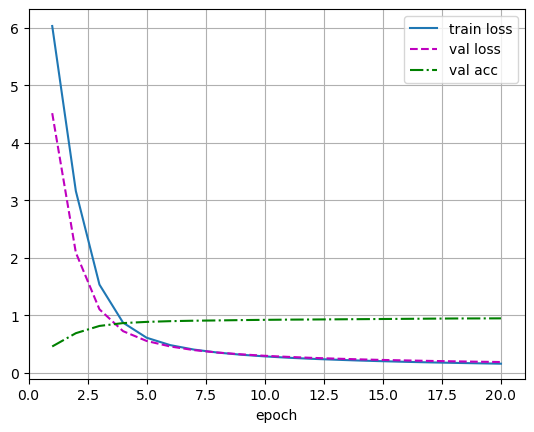

In [4]:
ml.train(num_epochs=20)  # 训练

In [5]:
ml.test()  # 测试

2025-05-24 14:06:26,348 - INFO: test acc 0.952


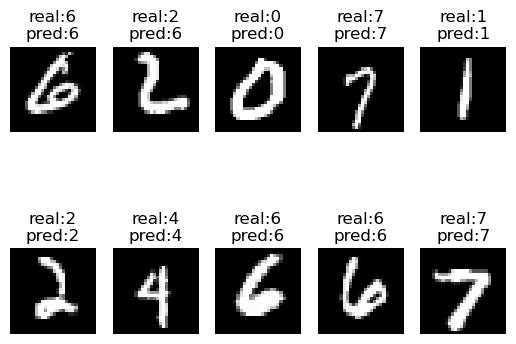

In [6]:
ml.predict()  # 预测